In [1]:
%reset -f
%matplotlib inline

In [33]:
import numpy as np
import scipy.io as sio
import sklearn as sk
from sklearn import decomposition

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd

import datetime

from scipy.io import savemat

In [3]:
cmap = sns.color_palette('RdBu',5)[:2] + sns.color_palette('RdBu',8)[-2:]
sns.set_palette(cmap)

In [4]:
data = sio.loadmat('/Users/jeff/Documents/Python/_projects/cyclingRNN/drakeFeb.mat')

In [5]:
m1 = data['D'][0,0]['M1']
emg = data['D'][0,0]['EMG']

m1 = np.reshape(m1, m1.shape[:2]+(4,)) # order = 'C' or 'F'
emg = np.reshape(emg, emg.shape[:2]+(4,)) # order = 'C' or 'F'

m1 = np.transpose(m1, [1,2,0])
emg = np.transpose(emg, [1,2,0])

print 'M1 shape '+str(m1.shape)
print 'EMG shape '+str(emg.shape)

M1 shape (5092, 4, 113)
EMG shape (5092, 4, 36)


## EMG plot

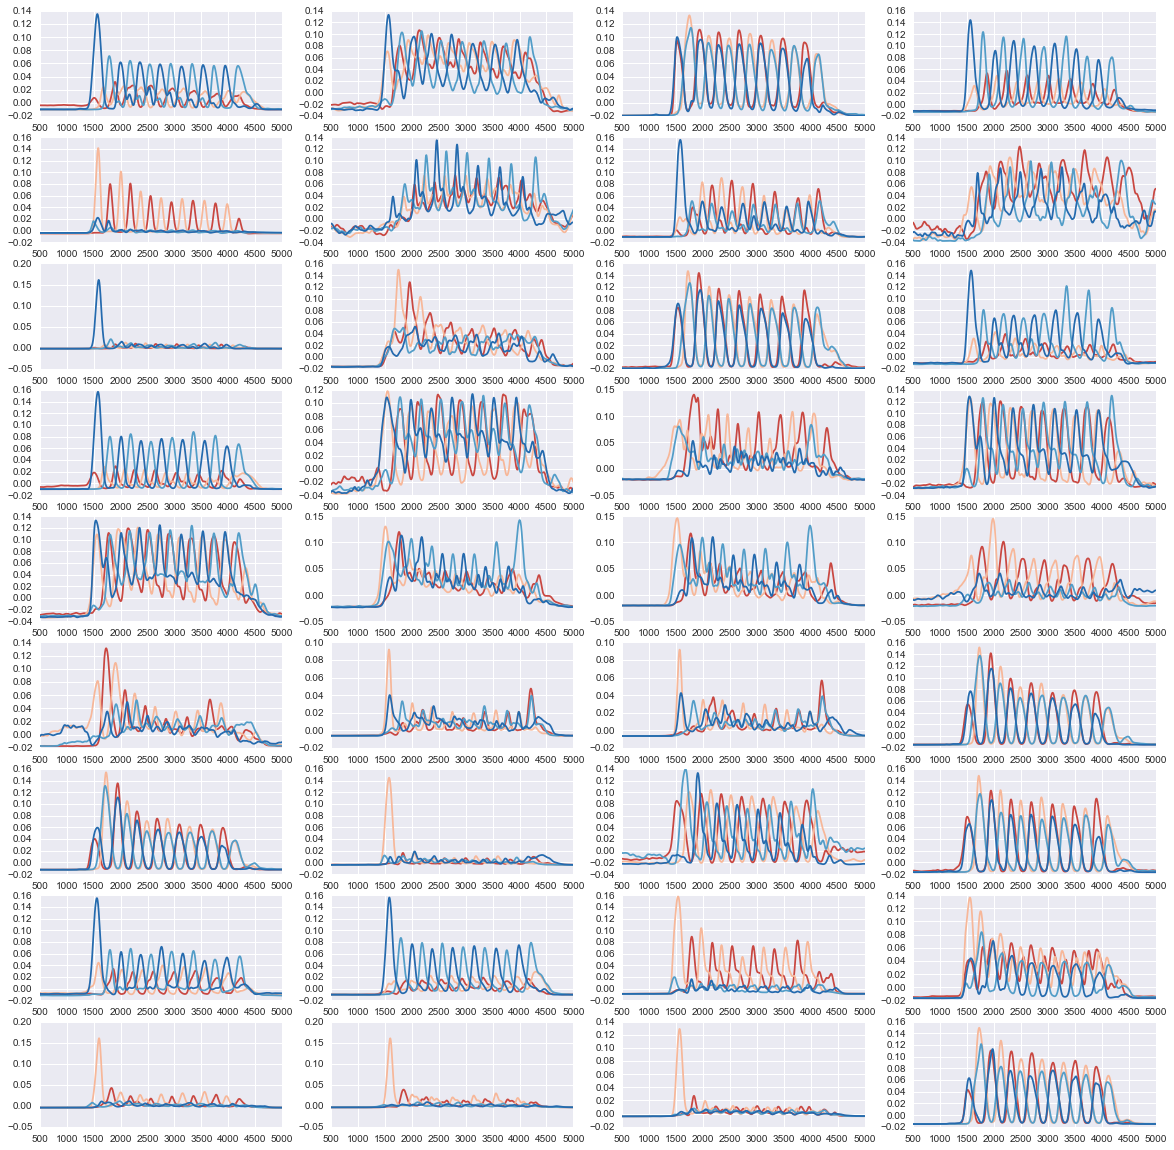

In [6]:
rows = 9
cols = 4
f, ax = plt.subplots(rows,cols, figsize=(20,20))

for i in range(rows):
    for j in range(cols):
        muscle = np.ravel_multi_index((i,j), (rows,cols))
        ax[i,j].plot(emg[:,:,muscle])
        ax[i,j].set_xlim((500,5000))
        #ax[i,j].set_title(str(muscle))
plt.show()

## Preprocess data

In [41]:
blah = np.arange(2000,4000,25)

In [44]:
blah[-1]

3975

In [46]:
emg.shape

(5092, 4, 36)

In [7]:
# Select times + downsample 
times = np.arange(2000,4000, 25)
m1_ = m1[times]
emg_ = emg[times]

In [8]:
# Normalize EMG
max_ = np.max(emg_, axis=(0,1))
min_ = np.min(emg_, axis=(0,1))
emg_ = (emg_ - min_)/(max_ - min_)

## Set up PCA for plotting

In [9]:
pca_emg = sk.decomposition.PCA(n_components=5)
pca_m1 = sk.decomposition.PCA(n_components=5)

pca_emg.fit(np.concatenate([emg_[:,i,:] for i in range(4)]))
pca_m1.fit(np.concatenate([m1_[:,i,:] for i in range(4)]))

PCA(copy=True, n_components=5, whiten=False)

In [10]:
def make_pairgrid(d):
    ''' in: (d1,d2,d3,d4) '''
    df = pd.DataFrame(np.concatenate(d))
    cond_labels = d[0].shape[0]*['fw1'] + d[1].shape[0]*['fw2'] + d[2].shape[0]*['bw1'] + d[3].shape[0]*['bw2']
    df['condition'] = cond_labels
    g = sns.PairGrid(df, hue='condition', diag_sharey=True)
    g.map_diag(plt.hist)
    g.map_offdiag(plt.plot)
    dmax = np.max(np.concatenate(d))
#     for i in range(g.axes.shape[0]):
#         for j in range(g.axes.shape[1]):
#             if i != j:
#                 g.axes[i,j].set_xlim(-dmax,dmax)
#                 g.axes[i,j].set_ylim(-dmax,dmax)
    
    g.add_legend()

#### PC plots, EMG

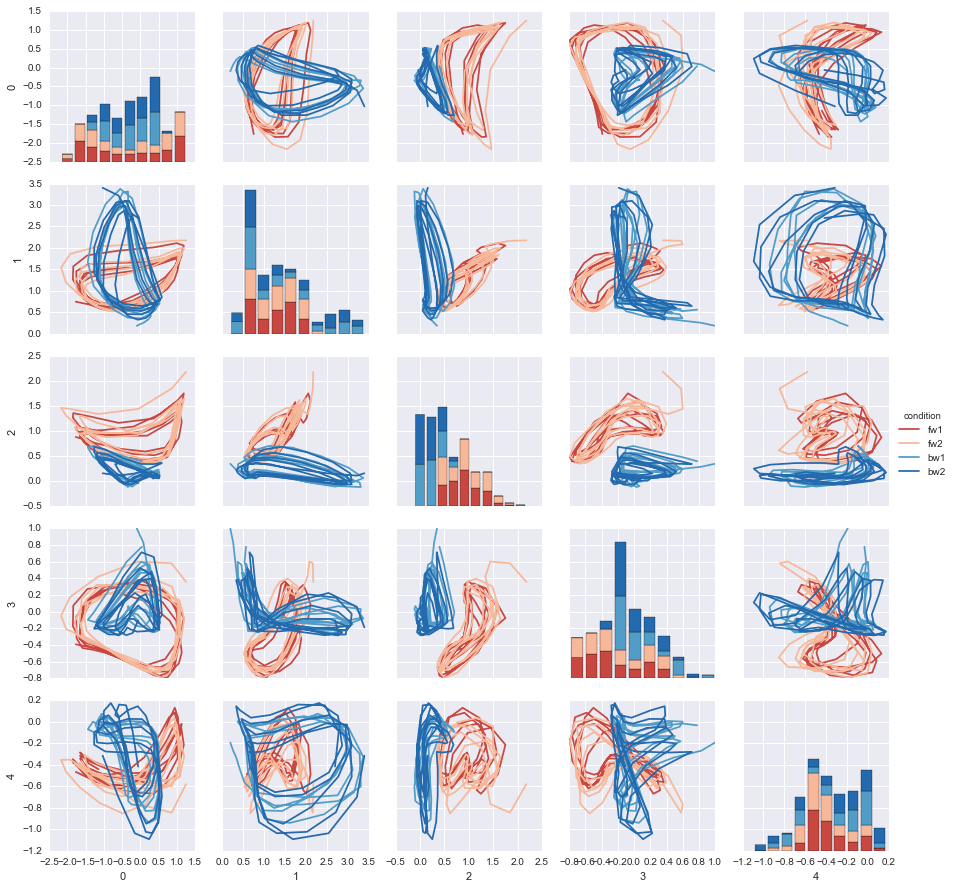

In [11]:
make_pairgrid([np.dot(emg_[:,i,:], pca_emg.components_.T) for i in range(4)])

#### PC plots, M1

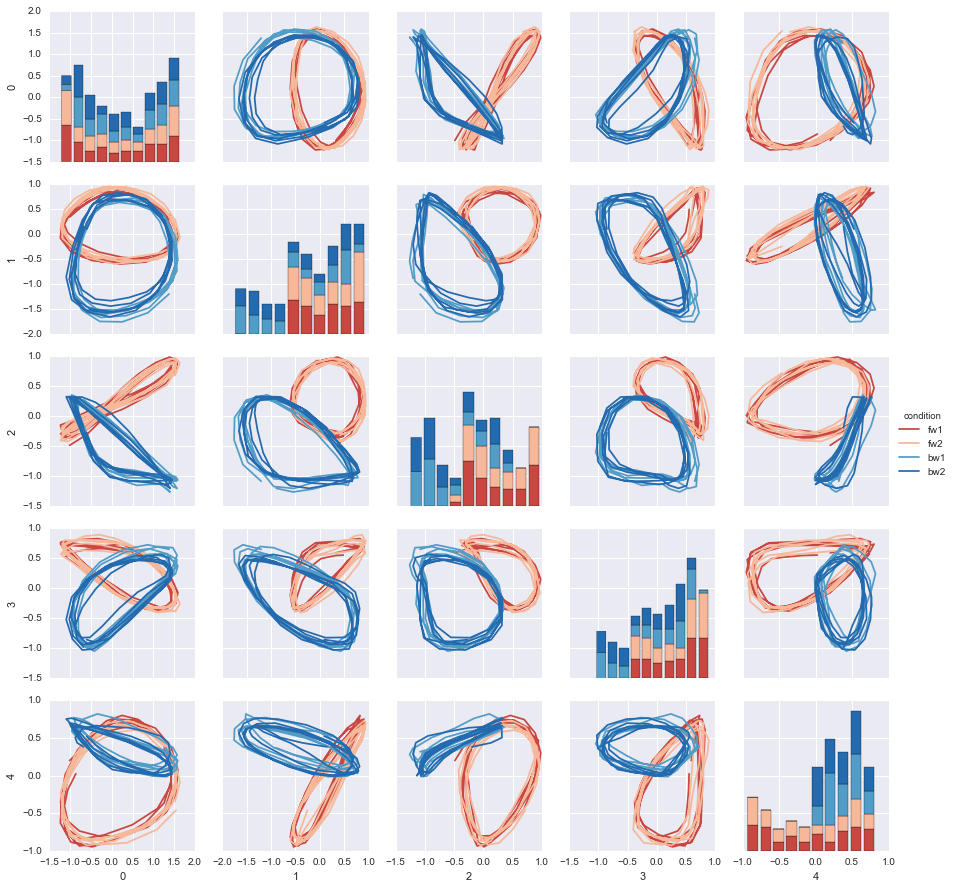

In [12]:
make_pairgrid([np.dot(m1_[:,i,:], pca_m1.components_.T) for i in range(4)])

## Set up input and output data for tensorflow

In [13]:
# # Some batch-related functions
# def hankelize(a, time_steps_):
#     """
#     Convert size (T,n) matrix to size (num_steps, T-num_steps+1 , n) tensor.
#     Different batches can now be selected by a[:,batch_inds,:].
#     """
#     dims = a.shape
#     T_new_ = dims[0] - time_steps_ + 1
#     b = np.zeros((T_new_, time_steps_) + dims[1:])
#     for i in range(T_new_):
#         b[i,:,:] = a[i:i+time_steps_, :]
#     inds = range(b.ndim)
#     inds[0], inds[1] = inds[1], inds[0]
#     b = np.transpose(b, inds) # |
#     return b

# def get_rand_batch(data_, batch_size_):
#     '''
#     args:
#     return:
#     '''
#     inds = np.random.choice(data_[0].shape[1], batch_size_)
#     for i in range(len(data_)):
#         data_[i] = data_[i][:,inds,:]
#     return inds, data_

# def get_next_batch(data_, batch_counter_):
#     """  """
#     batch_counter += 1
#     for i in range(len(data_)):
#         data_[i] = data_[i][:,inds,:]
#     return data_

In [14]:
# Time and batch parameters
time_steps = emg_.shape[0]
batch_size = 4
T = emg_.shape[0]
#T_new = T - time_steps + 1

In [15]:
# y_data_h = hankelize(emg_, time_steps)
# print y_data_h.shape

In [16]:
# # even partition
# y_data_e = y_data_h[:, :y_data_h.shape[1]:time_steps, :]
# print y_data_e.shape

In [17]:
# y_data = np.concatenate([y_data_e[:,:,:,i] for i in range(4)], axis=1)
# print y_data.shape

In [18]:
y_data = emg_

In [19]:
# Tensorflow requires inputs for its rnn helper functions.
# set input to zeros.
n = 50
u_data = np.zeros(y_data.shape[:2]+(n,))

In [20]:
print emg_.size
print y_data.size

11520
11520


## Build tensorflow graph

In [21]:
tf.reset_default_graph()

m = u_data.shape[-1] # not used
n = u_data.shape[-1] # n = 50 neurons
p = y_data.shape[-1] # p = 36 muscles
c = 4
total_batches = y_data.shape[1]

x0 = tf.Variable(tf.random_normal([total_batches,n], stddev=0.005), name='x0')

C = tf.Variable(tf.random_normal([n,p], stddev=1/np.sqrt(n)), name='C')
d = tf.Variable(tf.constant(0.01, shape=[1,p]), name='d')

U = tf.placeholder(tf.float32, [time_steps, None, n], name='U')
Y = tf.placeholder(tf.float32, [time_steps, None, p], name='Y')
#Inds = tf.placeholder(tf.int32, [None,], name='batch_inds')

cell = tf.nn.rnn_cell.BasicRNNCell(n)
#cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=0.5)
output, state = tf.nn.dynamic_rnn(cell, U, initial_state=x0, dtype=tf.float32, time_major=True)

Y_hat = tf.unpack(output)
Y_hat = [tf.matmul(Y_hat[i], C) + d for i in range(time_steps)]
Y_hat = tf.pack(Y_hat)

#output_diff = tf.gather(output, range(1,time_steps))-tf.gather(output, range(0,time_steps-1))

#Get A matrix
with tf.variable_scope('RNN/BasicRNNCell/Linear', reuse=True):
    A = tf.get_variable('Matrix')
    b = tf.get_variable('Bias')

In [22]:
beta1 = 0.0
beta2 = 0.0
gamma = 0.0
cost = tf.reduce_mean((Y_hat - Y)**2)
+beta1*tf.nn.l2_loss(A)
+beta2*tf.nn.l2_loss(C) 
#+gamma*tf.nn.l2_loss(output_diff)
        
train_op = tf.train.AdamOptimizer(learning_rate=0.00003) # add gradient_noise ? 
#grads_and_vars = train_op.compute_gradients(cost)
opt_op = train_op.minimize(cost)

In [23]:
tf.scalar_summary('loss', cost)
tf.histogram_summary('A', A)
tf.histogram_summary('b', b)
tf.histogram_summary('C', C)
tf.histogram_summary('d', d)

merged_summary_op = tf.merge_all_summaries()

In [24]:
saver = tf.train.Saver()
cur_run = str(datetime.datetime.now().strftime("%m%d-%H%M-%S"))
model_path = './saves/model'

## Train

In [27]:
with tf.Session() as sess:
    summary_writer = tf.train.SummaryWriter('/tmp/tensorflow_logs/'+cur_run, graph=sess.graph)
    sess.run(tf.initialize_all_variables())
    #saver.restore(sess, model_path)

    for i in range(50000):
        feed_dict = {Y: y_data, U: u_data}
        _, loss_val, summary_str = sess.run([opt_op, cost, merged_summary_op], feed_dict=feed_dict)
        summary_writer.add_summary(summary_str, i)

        if i % 500 == 0:
            print 'iter:', '%04d' % (i), \
                  'Loss:', '{:.6f}'.format(loss_val)
            saver.save(sess, model_path)

    print 'iter:', '%04d' % (i), \
          'Loss:', '{:.6f}'.format(loss_val)
    saver.save(sess, model_path)

    print 'Finished'

    # simulate model
    y_tf, x_tf = sess.run([Y_hat, output], feed_dict=feed_dict)

iter: 0000 Loss: 0.142084
iter: 0500 Loss: 0.061256
iter: 1000 Loss: 0.054099
iter: 1500 Loss: 0.052995
iter: 2000 Loss: 0.052310
iter: 2500 Loss: 0.051438
iter: 3000 Loss: 0.039283
iter: 3500 Loss: 0.033047
iter: 4000 Loss: 0.030820
iter: 4500 Loss: 0.029293
iter: 5000 Loss: 0.026500
iter: 5500 Loss: 0.019022
iter: 6000 Loss: 0.015145
iter: 6500 Loss: 0.013112
iter: 7000 Loss: 0.011941
iter: 7500 Loss: 0.011072
iter: 8000 Loss: 0.010504
iter: 8500 Loss: 0.009973
iter: 9000 Loss: 0.009565
iter: 9500 Loss: 0.009262
iter: 10000 Loss: 0.008939
iter: 10500 Loss: 0.008711
iter: 11000 Loss: 0.008417
iter: 11500 Loss: 0.008158
iter: 12000 Loss: 0.008055
iter: 12500 Loss: 0.007768
iter: 13000 Loss: 0.007617
iter: 13500 Loss: 0.007469
iter: 14000 Loss: 0.007281
iter: 14500 Loss: 0.007159
iter: 15000 Loss: 0.007306
iter: 15500 Loss: 0.006906
iter: 16000 Loss: 0.006913
iter: 16500 Loss: 0.006775
iter: 17000 Loss: 0.006735
iter: 17500 Loss: 0.006666
iter: 18000 Loss: 0.006633
iter: 18500 Loss: 0.0

In [ ]:
# def dehankelize(data_):
#     data_ = np.concatenate([data_[:,i,:] for i in range(data_.shape[1])])
#     data_ = np.reshape(data_, (data_.shape[0]/4, 4, data_.shape[1]), order='F')
#     data_ = np.transpose(data_, (0,2,1))
#     return data_

In [ ]:
# y_tf_ = dehankelize(y_tf)
# x_tf_ = dehankelize(x_tf)

## Plot fit quality

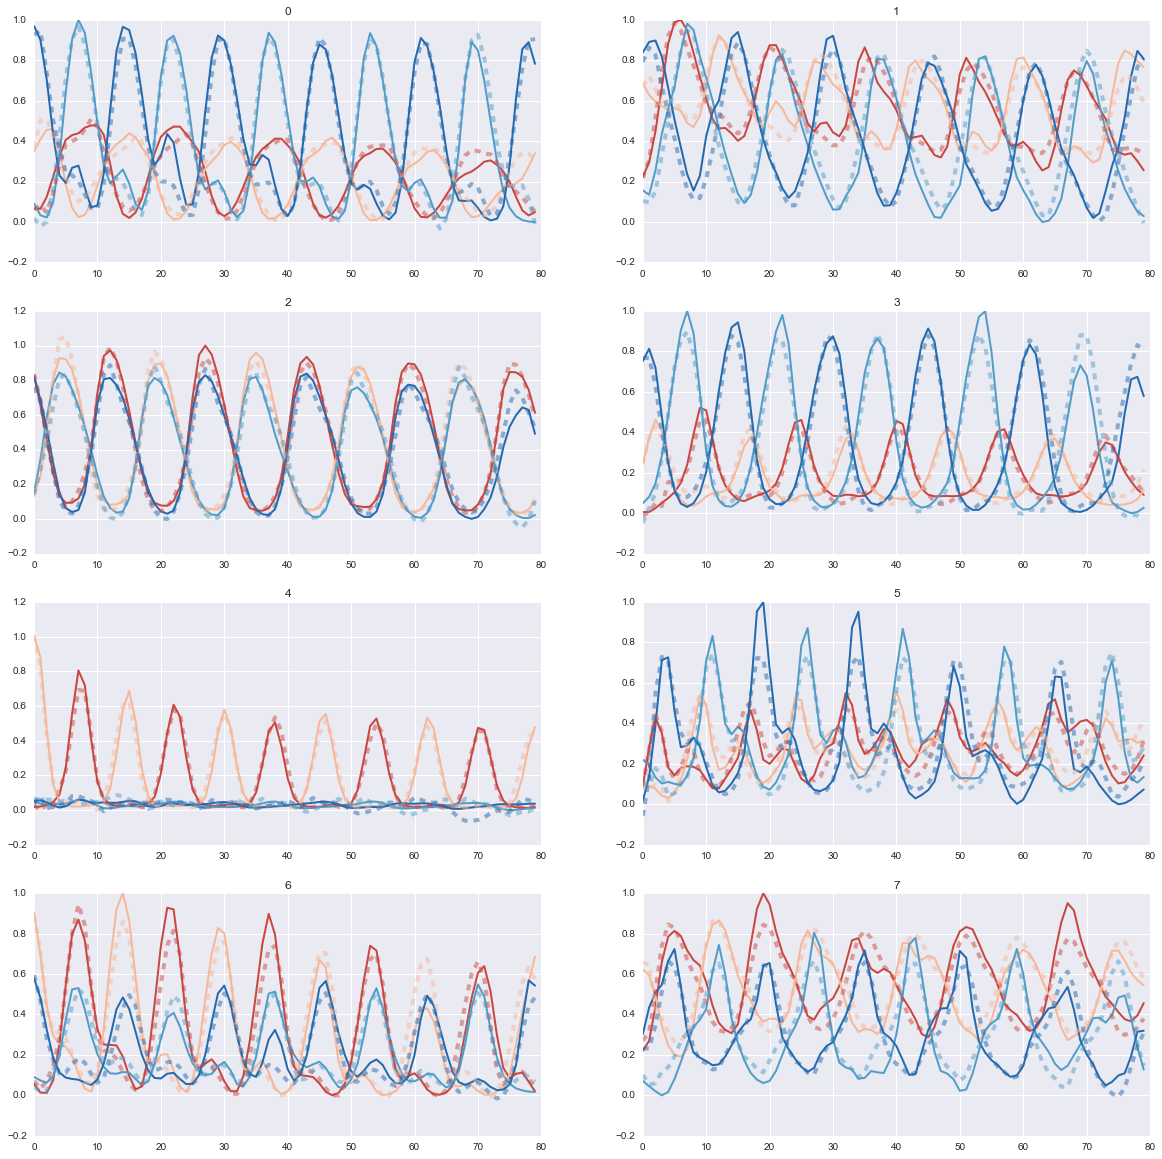

In [28]:
rows = 4
cols = 2

with sns.color_palette(n_colors=4):
    f, ax = plt.subplots(rows,cols, figsize=(20,20))
    for i in range(rows):
        for j in range(cols):
            muscle = np.ravel_multi_index((i,j), (rows,cols))
            ax[i,j].plot(emg_[:,:,muscle], linewidth=2, alpha=1)
            ax[i,j].plot(y_tf[:,:,muscle],'--',linewidth=4, alpha=0.5)
            ax[i,j].set_title(str(muscle))
plt.show()

## RNN neuron PC plots

In [29]:
pca_x = sk.decomposition.PCA(n_components=5)
pca_y = sk.decomposition.PCA(n_components=5)

pca_x.fit(np.concatenate([x_tf[:,i,:] for i in range(4)]))
pca_y.fit(np.concatenate([y_tf[:,i,:] for i in range(4)]))

PCA(copy=True, n_components=5, whiten=False)

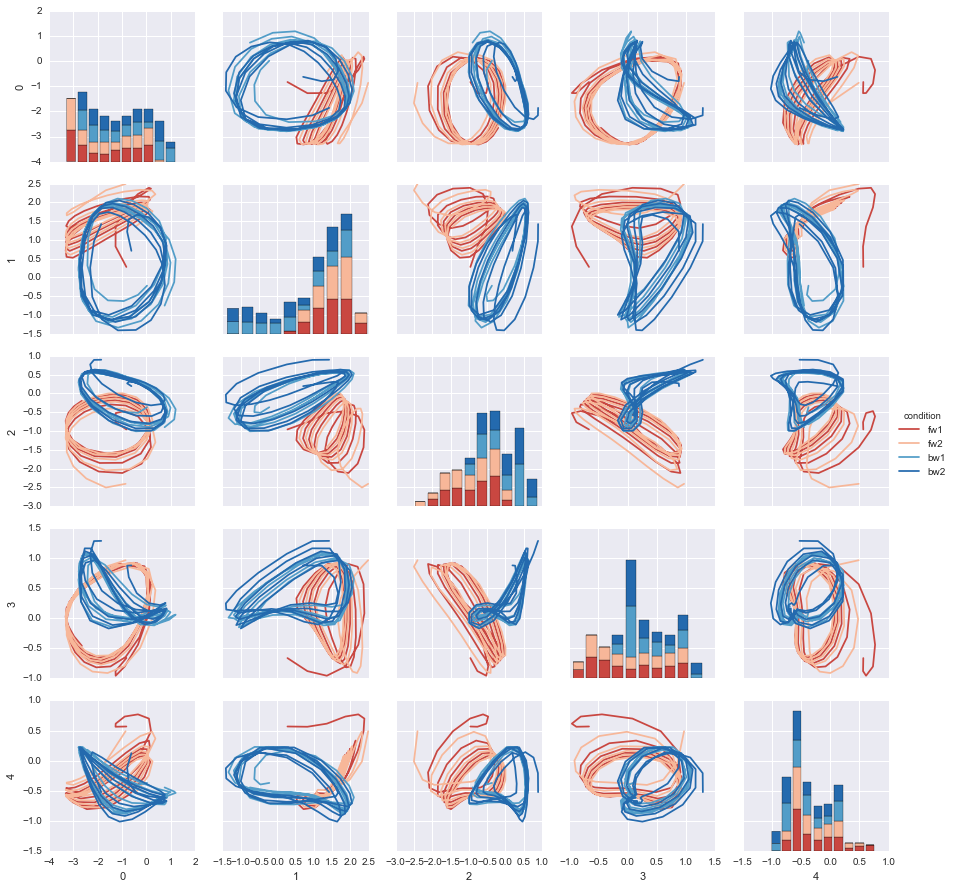

In [30]:
# plot PCs for the RNN state variable
make_pairgrid([np.dot(x_tf[:,i,:], pca_x.components_.T) for i in range(4)])

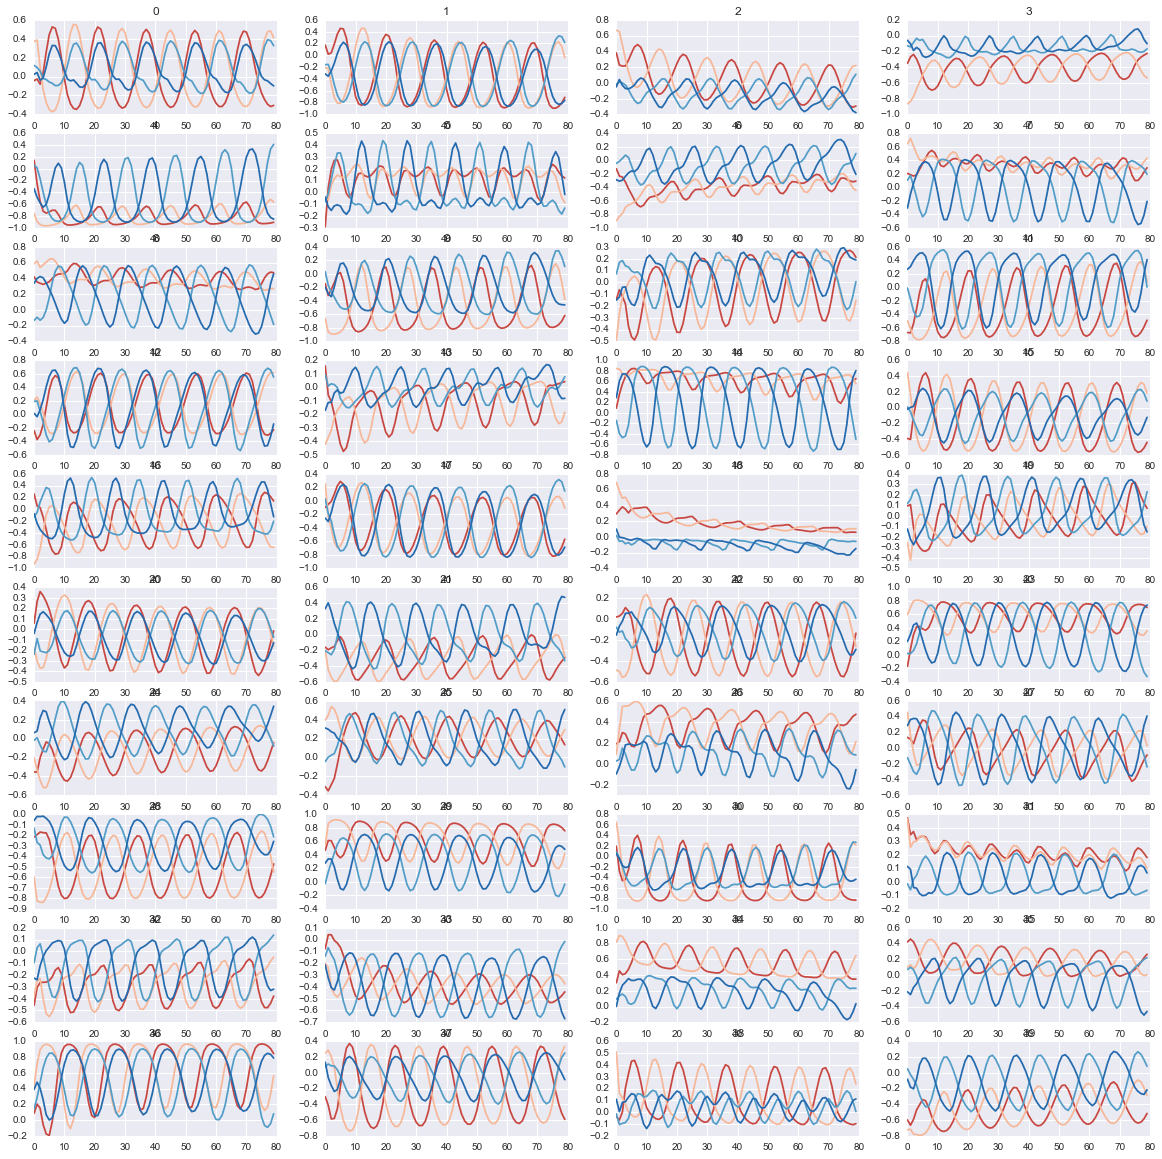

In [32]:
rows = 10
cols = 4
f, ax = plt.subplots(rows,cols, figsize=(20,20))

for i in range(rows):
    for j in range(cols):
        neuron = np.ravel_multi_index((i,j), (rows,cols))
        ax[i,j].plot(x_tf[:,:,neuron])
        ax[i,j].set_title(str(neuron))
plt.show()

### export to stupid lab

In [37]:
savemat('/Users/jeff/Documents/MATLAB/CyclingTask/data/states_drake.mat', mdict={'X': x_tf})